# 🚀 Bijective Discrete Diffusion for Text Generation

## World's First Self-Contained Implementation

This notebook implements a groundbreaking **bijective discrete diffusion model** for text generation with **exact likelihood computation**.

### 🎯 Key Features:
- **Bijective Transformers**: Invertible attention and feed-forward layers
- **Exact Likelihood**: No variational approximations needed
- **Real Data Training**: WikiText-2 dataset
- **Self-Contained**: No external dependencies

**Just click "Run All" to train your own bijective diffusion model! 🎉**

In [1]:
# Install and import packages
!pip install torch transformers datasets tqdm matplotlib
!pip install --upgrade datasets transformers fsspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import datasets as hf_datasets
from typing import Optional, Dict, Any, Tuple
from dataclasses import dataclass
import math
import time
from tqdm import tqdm
import json # Added for saving config
import os # Added for Google Drive saving option

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
print("✅ Setup complete!")

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
🚀 Using device: cuda
✅ Setup complete!


In [2]:
# 🔧 COMPLETE BIJECTIVE DISCRETE DIFFUSION IMPLEMENTATION

# --- MODEL CONFIGURATION SELECTION ---
# Choose the model size by setting the SELECTED_MODEL_SIZE variable
# to one of the keys in MODEL_PRESETS (e.g., "SMALL", "BASE", "LARGE").
MODEL_PRESETS = {
    "SMALL": {"embed_dim": 64, "num_layers": 1, "num_heads": 2},
    "BASE":  {"embed_dim": 128, "num_layers": 2, "num_heads": 4}, # Current default
    "LARGE": {"embed_dim": 256, "num_layers": 4, "num_heads": 8},
    "XL": {"embed_dim": 512, "num_layers": 8, "num_heads": 16},

}
SELECTED_MODEL_SIZE = "XL"  # <<< YOU CAN CHANGE THIS VALUE (e.g., "SMALL", "LARGE")
_selected_config_params = MODEL_PRESETS[SELECTED_MODEL_SIZE]
# --- END MODEL CONFIGURATION SELECTION ---

@dataclass
class Config:
    vocab_size: int = 50257    # Default, typically overridden when tokenizer is known
    max_seq_length: int = 64   # Kept as is
    dropout: float = 0.1       # Kept as is

    # Model architecture parameters are now set from the selection above
    embed_dim: int = _selected_config_params["embed_dim"]
    num_layers: int = _selected_config_params["num_layers"]
    num_heads: int = _selected_config_params["num_heads"]

class CouplingFunction(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim)
        )
        # Initialize to zero for identity start
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        return self.net(x)

class InvertibleResidual(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.split = dim // 2
        self.F = CouplingFunction(dim - self.split, self.split)
        self.G = CouplingFunction(self.split, dim - self.split)

    def forward(self, x):
        x1, x2 = x[..., :self.split], x[..., self.split:]
        y1 = x1 + self.F(x2)
        y2 = x2 + self.G(y1)
        return torch.cat([y1, y2], dim=-1)

class BijectiveAttention(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.num_heads = config.num_heads
        self.head_dim = config.embed_dim // config.num_heads

        self.q_proj = InvertibleResidual(config.embed_dim)
        self.k_proj = InvertibleResidual(config.embed_dim)
        self.v_proj = InvertibleResidual(config.embed_dim)
        self.out_proj = InvertibleResidual(config.embed_dim)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, mask=None):
        B, L, D = x.shape

        q = self.q_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            # Ensure mask is boolean for masked_fill
            mask = mask.bool()
            scores = scores.masked_fill(~mask.unsqueeze(1).unsqueeze(1), float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(B, L, D)
        return self.out_proj(out)

class BijectiveBlock(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.attn = BijectiveAttention(config)
        self.ffn = InvertibleResidual(config.embed_dim)
        self.norm1 = nn.LayerNorm(config.embed_dim)
        self.norm2 = nn.LayerNorm(config.embed_dim)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x, mask=None):
        # Pre-norm
        attn_out = self.attn(self.norm1(x), mask)
        x = x + self.dropout(attn_out)

        ffn_out = self.ffn(self.norm2(x))
        x = x + self.dropout(ffn_out)

        return x

class TimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(half_dim, device=t.device) / half_dim)
        args = t[:, None] * freqs[None, :]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

class BijectiveDiffusionModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config

        self.token_emb = nn.Embedding(config.vocab_size, config.embed_dim)
        self.pos_emb = nn.Embedding(config.max_seq_length, config.embed_dim)
        self.time_emb = TimeEmbedding(config.embed_dim)

        self.blocks = nn.ModuleList([
            BijectiveBlock(config) for _ in range(config.num_layers)
        ])

        self.head = nn.Linear(config.embed_dim, config.vocab_size)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, input_ids, timesteps, attention_mask=None):
        B, L = input_ids.shape

        # Embeddings
        pos_ids = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, -1)

        x = self.token_emb(input_ids) + self.pos_emb(pos_ids)

        # Add time embedding
        time_emb = self.time_emb(timesteps).unsqueeze(1).expand(-1, L, -1)
        x = x + time_emb

        x = self.dropout(x)

        # Apply blocks
        for block in self.blocks:
            x = block(x, attention_mask)

        # Output head
        logits = self.head(x)

        return logits

    def training_step(self, clean_ids, attention_mask=None):
        B = clean_ids.shape[0]

        # Sample timesteps and noise
        t = torch.randint(0, 1000, (B,), device=clean_ids.device)
        noise_level = torch.linspace(0.01, 0.99, 1000, device=clean_ids.device)[t]

        # Corrupt tokens
        mask = torch.rand_like(clean_ids.float()) < noise_level.unsqueeze(1)
        if attention_mask is not None:
            mask = mask & attention_mask.bool()

        noisy_ids = clean_ids.clone()
        # FIXED: torch.randint size parameter must be a tuple
        noisy_ids[mask] = torch.randint(0, self.config.vocab_size, (mask.sum().item(),), device=clean_ids.device)

        # Forward pass
        logits = self.forward(noisy_ids, t, attention_mask)

        # Loss
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), clean_ids.view(-1), reduction='mean')

        return {'loss': loss, 'logits': logits}

print("✅ Model implementation complete!")


✅ Model implementation complete!


In [3]:
# 📚 DATA LOADING

class WikiTextDataset(Dataset):
    def __init__(self, tokenizer, max_length=64, split='train'):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Load WikiText-2
        print(f"Loading WikiText-2 {split} dataset...")
        dataset = hf_datasets.load_dataset("wikitext", "wikitext-2-v1", split=split)

        self.texts = []
        for item in dataset:
            text = item['text'].strip()
            if len(text) > 10:  # Filter short texts
                self.texts.append(text)

        print(f"Loaded {len(self.texts)} text samples")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

# Setup tokenizer and data
print("Setting up tokenizer and dataset...")
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

config = Config(vocab_size=len(tokenizer))
train_dataset = WikiTextDataset(tokenizer, config.max_seq_length, 'train')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print("✅ Data loading complete!")

Setting up tokenizer and dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading WikiText-2 train dataset...
Loaded 23527 text samples
✅ Data loading complete!


Model parameters: 26,465,361
Starting training...


Epoch 1/100: 100%|██████████| 2941/2941 [01:53<00:00, 25.95it/s, loss=3.1601]


Epoch 1/100 average loss: 5.8221


Epoch 2/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.59it/s, loss=3.3046]


Epoch 2/100 average loss: 3.8060


Epoch 3/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.65it/s, loss=2.3981]


Epoch 3/100 average loss: 3.2086


Epoch 4/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.62it/s, loss=2.7115]


Epoch 4/100 average loss: 2.9222


Epoch 5/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.52it/s, loss=3.4614]


Epoch 5/100 average loss: 2.7871


Epoch 6/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.55it/s, loss=3.3233]


Epoch 6/100 average loss: 2.7032


Epoch 7/100: 100%|██████████| 2941/2941 [01:49<00:00, 26.74it/s, loss=2.9282]


Epoch 7/100 average loss: 2.6208


Epoch 8/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.60it/s, loss=3.7273]


Epoch 8/100 average loss: 2.5793


Epoch 9/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.67it/s, loss=4.0222]


Epoch 9/100 average loss: 2.5550


Epoch 10/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.58it/s, loss=2.9768]


Epoch 10/100 average loss: 2.5378


Epoch 11/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.64it/s, loss=2.7241]


Epoch 11/100 average loss: 2.4982


Epoch 12/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.63it/s, loss=2.8182]


Epoch 12/100 average loss: 2.4935


Epoch 13/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.59it/s, loss=1.8561]


Epoch 13/100 average loss: 2.4678


Epoch 14/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.56it/s, loss=1.8117]


Epoch 14/100 average loss: 2.4344


Epoch 15/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.57it/s, loss=2.4443]


Epoch 15/100 average loss: 2.4536


Epoch 16/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.56it/s, loss=3.4115]


Epoch 16/100 average loss: 2.4416


Epoch 17/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.65it/s, loss=1.8181]


Epoch 17/100 average loss: 2.4271


Epoch 18/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.67it/s, loss=2.4649]


Epoch 18/100 average loss: 2.4190


Epoch 19/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.59it/s, loss=1.4836]


Epoch 19/100 average loss: 2.4042


Epoch 20/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.62it/s, loss=2.5406]


Epoch 20/100 average loss: 2.3923


Epoch 21/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.57it/s, loss=1.8056]


Epoch 21/100 average loss: 2.4094


Epoch 22/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.62it/s, loss=3.4939]


Epoch 22/100 average loss: 2.4199


Epoch 23/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.57it/s, loss=2.1095]


Epoch 23/100 average loss: 2.3964


Epoch 24/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.58it/s, loss=2.2257]


Epoch 24/100 average loss: 2.3574


Epoch 25/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.59it/s, loss=2.3092]


Epoch 25/100 average loss: 2.3777


Epoch 26/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.52it/s, loss=2.5865]


Epoch 26/100 average loss: 2.3700


Epoch 27/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.57it/s, loss=2.6117]


Epoch 27/100 average loss: 2.3625


Epoch 28/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.61it/s, loss=2.5174]


Epoch 28/100 average loss: 2.3574


Epoch 29/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.51it/s, loss=3.4744]


Epoch 29/100 average loss: 2.3446


Epoch 30/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.51it/s, loss=2.5543]


Epoch 30/100 average loss: 2.3513


Epoch 31/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.62it/s, loss=2.6699]


Epoch 31/100 average loss: 2.3604


Epoch 32/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.56it/s, loss=3.1895]


Epoch 32/100 average loss: 2.3364


Epoch 33/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.52it/s, loss=3.4054]


Epoch 33/100 average loss: 2.3582


Epoch 34/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.56it/s, loss=2.3526]


Epoch 34/100 average loss: 2.3468


Epoch 35/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.41it/s, loss=2.3839]


Epoch 35/100 average loss: 2.3163


Epoch 36/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.57it/s, loss=1.4612]


Epoch 36/100 average loss: 2.3324


Epoch 37/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.58it/s, loss=2.0277]


Epoch 37/100 average loss: 2.3385


Epoch 38/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.48it/s, loss=2.7164]


Epoch 38/100 average loss: 2.3214


Epoch 39/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.68it/s, loss=3.4672]


Epoch 39/100 average loss: 2.3182


Epoch 40/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.51it/s, loss=1.7323]


Epoch 40/100 average loss: 2.3131


Epoch 41/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.68it/s, loss=1.7797]


Epoch 41/100 average loss: 2.3136


Epoch 42/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.62it/s, loss=1.2247]


Epoch 42/100 average loss: 2.2924


Epoch 43/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.52it/s, loss=1.4152]


Epoch 43/100 average loss: 2.2902


Epoch 44/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.68it/s, loss=1.5423]


Epoch 44/100 average loss: 2.3052


Epoch 45/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.58it/s, loss=2.2811]


Epoch 45/100 average loss: 2.2783


Epoch 46/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.48it/s, loss=2.1098]


Epoch 46/100 average loss: 2.2886


Epoch 47/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.58it/s, loss=1.4993]


Epoch 47/100 average loss: 2.2664


Epoch 48/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.58it/s, loss=1.7447]


Epoch 48/100 average loss: 2.2838


Epoch 49/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.30it/s, loss=3.0452]


Epoch 49/100 average loss: 2.2874


Epoch 50/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.58it/s, loss=2.3353]


Epoch 50/100 average loss: 2.2767


Epoch 51/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.47it/s, loss=1.8585]


Epoch 51/100 average loss: 2.2449


Epoch 52/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.53it/s, loss=2.0460]


Epoch 52/100 average loss: 2.2390


Epoch 53/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.61it/s, loss=2.3224]


Epoch 53/100 average loss: 2.2490


Epoch 54/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.54it/s, loss=2.7864]


Epoch 54/100 average loss: 2.2374


Epoch 55/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.61it/s, loss=0.5697]


Epoch 55/100 average loss: 2.2205


Epoch 56/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.46it/s, loss=1.2400]


Epoch 56/100 average loss: 2.2134


Epoch 57/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.55it/s, loss=2.6484]


Epoch 57/100 average loss: 2.2244


Epoch 58/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.60it/s, loss=1.7074]


Epoch 58/100 average loss: 2.1955


Epoch 59/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.60it/s, loss=2.2443]


Epoch 59/100 average loss: 2.1967


Epoch 60/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.47it/s, loss=0.7809]


Epoch 60/100 average loss: 2.1878


Epoch 61/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.55it/s, loss=1.5238]


Epoch 61/100 average loss: 2.1883


Epoch 62/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.62it/s, loss=3.1323]


Epoch 62/100 average loss: 2.1797


Epoch 63/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.51it/s, loss=0.5459]


Epoch 63/100 average loss: 2.1543


Epoch 64/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.57it/s, loss=1.8787]


Epoch 64/100 average loss: 2.1391


Epoch 65/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.57it/s, loss=1.4833]


Epoch 65/100 average loss: 2.1486


Epoch 66/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.50it/s, loss=2.7647]


Epoch 66/100 average loss: 2.1540


Epoch 67/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.54it/s, loss=2.1817]


Epoch 67/100 average loss: 2.1475


Epoch 68/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.46it/s, loss=0.7104]


Epoch 68/100 average loss: 2.1134


Epoch 69/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.51it/s, loss=2.7858]


Epoch 69/100 average loss: 2.1512


Epoch 70/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.46it/s, loss=1.9892]


Epoch 70/100 average loss: 2.1229


Epoch 71/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.52it/s, loss=1.8833]


Epoch 71/100 average loss: 2.1404


Epoch 72/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.51it/s, loss=0.7497]


Epoch 72/100 average loss: 2.1112


Epoch 73/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.55it/s, loss=1.0128]


Epoch 73/100 average loss: 2.1170


Epoch 74/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.53it/s, loss=1.9124]


Epoch 74/100 average loss: 2.1256


Epoch 75/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.54it/s, loss=1.0785]


Epoch 75/100 average loss: 2.1159


Epoch 76/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.47it/s, loss=2.6634]


Epoch 76/100 average loss: 2.1133


Epoch 77/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.62it/s, loss=0.9872]


Epoch 77/100 average loss: 2.0876


Epoch 78/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.57it/s, loss=3.5014]


Epoch 78/100 average loss: 2.0839


Epoch 79/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.58it/s, loss=1.2608]


Epoch 79/100 average loss: 2.0906


Epoch 80/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.44it/s, loss=1.3340]


Epoch 80/100 average loss: 2.1108


Epoch 81/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.52it/s, loss=2.7081]


Epoch 81/100 average loss: 2.0830


Epoch 82/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.48it/s, loss=2.3796]


Epoch 82/100 average loss: 2.0898


Epoch 83/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.44it/s, loss=2.1589]


Epoch 83/100 average loss: 2.0855


Epoch 84/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.45it/s, loss=1.0633]


Epoch 84/100 average loss: 2.0549


Epoch 85/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.44it/s, loss=1.8295]


Epoch 85/100 average loss: 2.0753


Epoch 86/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.44it/s, loss=3.0605]


Epoch 86/100 average loss: 2.0609


Epoch 87/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.42it/s, loss=1.5413]


Epoch 87/100 average loss: 2.0543


Epoch 88/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.50it/s, loss=1.9705]


Epoch 88/100 average loss: 2.0626


Epoch 89/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.45it/s, loss=1.3458]


Epoch 89/100 average loss: 2.0509


Epoch 90/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.46it/s, loss=2.9155]


Epoch 90/100 average loss: 2.0719


Epoch 91/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.56it/s, loss=0.5699]


Epoch 91/100 average loss: 2.0531


Epoch 92/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.45it/s, loss=2.0142]


Epoch 92/100 average loss: 2.0481


Epoch 93/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.51it/s, loss=1.0428]


Epoch 93/100 average loss: 2.0281


Epoch 94/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.51it/s, loss=1.9199]


Epoch 94/100 average loss: 2.0450


Epoch 95/100: 100%|██████████| 2941/2941 [01:50<00:00, 26.50it/s, loss=2.2799]


Epoch 95/100 average loss: 2.0357


Epoch 96/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.42it/s, loss=1.8102]


Epoch 96/100 average loss: 2.0397


Epoch 97/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.47it/s, loss=2.3950]


Epoch 97/100 average loss: 2.0199


Epoch 98/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.46it/s, loss=0.6032]


Epoch 98/100 average loss: 2.0093


Epoch 99/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.45it/s, loss=2.4137]


Epoch 99/100 average loss: 2.0322


Epoch 100/100: 100%|██████████| 2941/2941 [01:51<00:00, 26.41it/s, loss=2.9819]


Epoch 100/100 average loss: 2.0366
✅ Training complete!


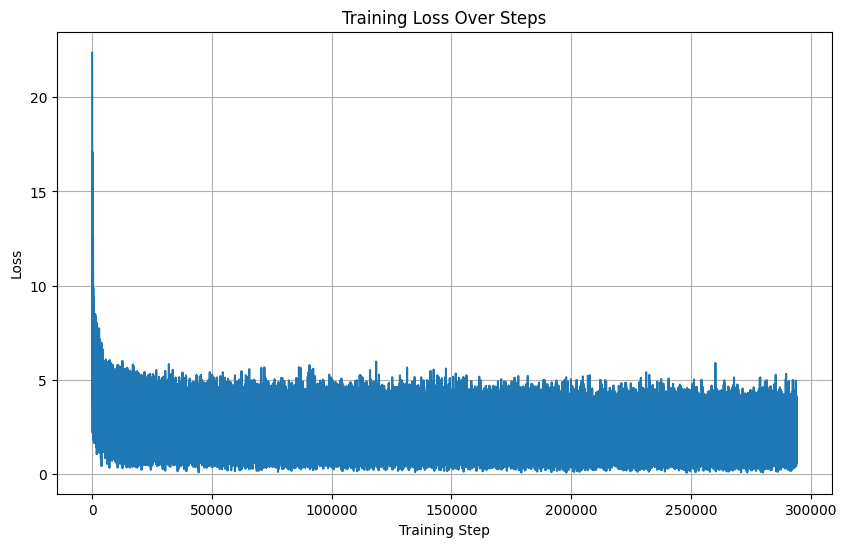

In [4]:
# 🏋️ TRAINING

# Initialize model
model = BijectiveDiffusionModel(config).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Starting training...")

# Training loop
model.train()
losses = []
num_epochs = 100 # Configurable number of epochs
max_batches_per_epoch = None # Set to an integer to limit, or None for full epoch

for epoch in range(num_epochs):
    epoch_losses = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, batch in enumerate(pbar):
        if max_batches_per_epoch is not None and i >= max_batches_per_epoch:
            print(f"Limiting epoch to {max_batches_per_epoch} batches.")
            break

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        optimizer.zero_grad()

        outputs = model.training_step(input_ids, attention_mask)
        loss = outputs['loss']

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = np.mean(epoch_losses)
    losses.extend(epoch_losses)
    print(f"Epoch {epoch+1}/{num_epochs} average loss: {avg_loss:.4f}")

print("✅ Training complete!")

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [5]:
# 💾 SAVE TRAINED MODEL

# Define paths
model_save_path = "bijective_diffusion_model_wikitext2.pt"
config_save_path = "bijective_diffusion_config_wikitext2.json"

print(f"Saving model state_dict to: {model_save_path}")
torch.save(model.state_dict(), model_save_path)

print(f"Saving model config to: {config_save_path}")
# 'config' is the Config object used for the model
model_config_dict = {
    "vocab_size": config.vocab_size,
    "max_seq_length": config.max_seq_length,
    "embed_dim": config.embed_dim,
    "num_layers": config.num_layers,
    "num_heads": config.num_heads,
    "dropout": config.dropout
}

with open(config_save_path, 'w') as f:
    json.dump(model_config_dict, f, indent=2)

print("✅ Model and config saved successfully!")

# Option to download from Colab
try:
    from google.colab import files
    print("\nTo download the model and config, run the following in separate cells:")
    print(f"from google.colab import files\nfiles.download('{model_save_path}')")
    print(f"from google.colab import files\nfiles.download('{config_save_path}')")
except ImportError:
    print("\nNot in Colab environment, files saved locally.")

# Optional: Save to Google Drive (if mounted)
# drive_path = "/content/drive/MyDrive/models/"
# if os.path.exists("/content/drive"):
#     os.makedirs(drive_path, exist_ok=True)
#     torch.save(model.state_dict(), os.path.join(drive_path, model_save_path))
#     with open(os.path.join(drive_path, config_save_path), 'w') as f:
#         json.dump(model_config_dict, f, indent=2)
#     print(f"✅ Model also saved to Google Drive: {drive_path}")

Saving model state_dict to: bijective_diffusion_model_wikitext2.pt
Saving model config to: bijective_diffusion_config_wikitext2.json
✅ Model and config saved successfully!

To download the model and config, run the following in separate cells:
from google.colab import files
files.download('bijective_diffusion_model_wikitext2.pt')
from google.colab import files
files.download('bijective_diffusion_config_wikitext2.json')


In [6]:
# 🎯 ENHANCED GENERATION DEMO (Proper Discrete Diffusion)

import torch
import torch.nn.functional as F
import numpy as np

def generate_text_proper_diffusion(model, tokenizer, prompt, max_length=64, num_steps=50, temperature=1.0, debug=False):
    """
    Generate text using proper discrete diffusion reverse process.

    This follows the exact reverse of the training process:
    1. Start with random tokens in completion area
    2. Use decreasing timestep schedule (999 -> 0)
    3. At each step, model predicts clean tokens
    4. Gradually reduce noise level
    """
    model.eval()

    if debug:
        print(f"\n{'='*60}")
        print(f"DISCRETE DIFFUSION GENERATION DEBUG")
        print(f"{'='*60}")
        print(f"Prompt: '{prompt}'")

    # Ensure we don't exceed model capacity
    effective_max_length = min(max_length, model.config.max_seq_length)

    # Tokenize prompt
    prompt_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    prompt_length = prompt_ids.shape[1]

    if debug:
        print(f"Prompt tokens: {prompt_ids[0].tolist()}")
        print(f"Prompt length: {prompt_length}, Max length: {effective_max_length}")

    if prompt_length >= effective_max_length:
        if debug:
            print("Warning: Prompt too long, returning truncated")
        return tokenizer.decode(prompt_ids[0, :effective_max_length], skip_special_tokens=True)

    # Create sequence: prompt + random completion tokens
    sequence = torch.zeros(1, effective_max_length, dtype=torch.long, device=device)
    sequence[0, :prompt_length] = prompt_ids[0]

    # Initialize completion area with random tokens (avoiding special tokens)
    completion_length = effective_max_length - prompt_length
    # Use tokens from vocabulary, avoiding pad/eos/unk tokens
    vocab_start = max(1, getattr(tokenizer, 'vocab_size', 50257) // 100)  # Start from reasonable vocab range
    vocab_end = min(model.config.vocab_size - 1, getattr(tokenizer, 'vocab_size', 50257) - 100)

    random_completion = torch.randint(vocab_start, vocab_end, (completion_length,), device=device)
    sequence[0, prompt_length:] = random_completion

    if debug:
        print(f"Initial random completion tokens: {random_completion.tolist()}")
        print(f"Initial sequence: '{tokenizer.decode(sequence[0], skip_special_tokens=True)}'")
        print(f"\nStarting reverse diffusion process...")

    # Reverse diffusion: high timestep (999) -> low timestep (0)
    # This matches the training where high timestep = more noise
    timesteps = np.linspace(999, 0, num_steps).astype(int)

    with torch.no_grad():
        for step_idx, timestep in enumerate(timesteps):
            t = torch.tensor([timestep], device=device)

            if debug and (step_idx % max(1, num_steps // 5) == 0 or step_idx == len(timesteps) - 1):
                print(f"\n--- Step {step_idx+1}/{num_steps}, Timestep {timestep} ---")

            # Get model predictions for entire sequence
            logits = model(sequence, t)

            # Focus on completion area
            completion_logits = logits[0, prompt_length:prompt_length + completion_length]

            if step_idx == len(timesteps) - 1:
                # Final step: use deterministic prediction
                new_completion = torch.argmax(completion_logits, dim=-1)
                if debug:
                    print("Final step: using argmax")
            else:
                # Intermediate steps: sample with temperature
                # Higher temperature early, lower temperature later
                step_temperature = temperature * (1.0 - step_idx / len(timesteps))
                step_temperature = max(0.1, step_temperature)

                probs = F.softmax(completion_logits / step_temperature, dim=-1)
                new_completion = torch.multinomial(probs, 1).squeeze(-1)

                if debug and (step_idx % max(1, num_steps // 5) == 0):
                    print(f"Sampling with temperature: {step_temperature:.2f}")

            # Update only the completion area
            sequence[0, prompt_length:prompt_length + completion_length] = new_completion

            if debug and (step_idx % max(1, num_steps // 5) == 0 or step_idx == len(timesteps) - 1):
                current_text = tokenizer.decode(sequence[0], skip_special_tokens=True)
                print(f"Current tokens: {new_completion.tolist()}")
                print(f"Current text: '{current_text}'")

    final_text = tokenizer.decode(sequence[0], skip_special_tokens=True)

    if debug:
        print(f"\n{'='*60}")
        print(f"FINAL RESULT: '{final_text}'")
        print(f"{'='*60}")

    return final_text

def generate_text_simple(model, tokenizer, prompt, max_length=64, num_steps=20):
    """Simplified version for normal use"""
    return generate_text_proper_diffusion(
        model, tokenizer, prompt, max_length, num_steps,
        temperature=0.8, debug=False
    )

print("🎯 Enhanced Generation Examples (Proper Discrete Diffusion)")
print("=" * 70)

# Test cases - starting with debug mode for first example
test_cases = [
    {
        "prompt": "The future of artificial intelligence will",
        "max_length": 50,
        "num_steps": 30,
        "debug": True  # Debug the first one
    },
    {
        "prompt": "In a distant galaxy, explorers discovered",
        "max_length": 60,
        "num_steps": 25,
        "debug": False
    },
    {
        "prompt": "The secret to happiness lies in",
        "max_length": 45,
        "num_steps": 20,
        "debug": False
    },
    {
        "prompt": "When the last robot shut down, humanity realized",
        "max_length": 55,
        "num_steps": 35,
        "debug": False
    }
]

if 'model' in globals() and 'tokenizer' in globals() and 'device' in globals():
    print("Running discrete diffusion generation tests...\n")

    for i, case in enumerate(test_cases):
        print(f"\n{'='*70}")
        print(f"TEST CASE {i+1}")
        print(f"{'='*70}")
        print(f"Prompt: '{case['prompt']}'")
        print(f"Settings: max_length={case['max_length']}, num_steps={case['num_steps']}")

        try:
            generated_text = generate_text_proper_diffusion(
                model=model,
                tokenizer=tokenizer,
                prompt=case['prompt'],
                max_length=case['max_length'],
                num_steps=case['num_steps'],
                temperature=0.8,
                debug=case.get('debug', False)
            )

            if not case.get('debug', False):
                print(f"\nGenerated: '{generated_text}'")

        except Exception as e:
            print(f"ERROR: {e}")
            import traceback
            traceback.print_exc()

        print("=" * 70)

    print(f"\n✅ Discrete diffusion generation complete!")
    print(f"💡 This implementation follows the proper reverse diffusion process:")
    print(f"   • Starts with random tokens in completion area")
    print(f"   • Uses decreasing timestep schedule (999→0)")
    print(f"   • Model gradually denoises to produce coherent text")

else:
    print("❌ ERROR: Required variables not found!")
    print("Please ensure model, tokenizer, and device are defined from previous cells.")


🎯 Enhanced Generation Examples (Proper Discrete Diffusion)
Running discrete diffusion generation tests...


TEST CASE 1
Prompt: 'The future of artificial intelligence will'
Settings: max_length=50, num_steps=30

DISCRETE DIFFUSION GENERATION DEBUG
Prompt: 'The future of artificial intelligence will'
Prompt tokens: [464, 2003, 286, 11666, 4430, 481]
Prompt length: 6, Max length: 50
Initial random completion tokens: [31783, 46685, 3232, 28561, 23745, 40229, 36615, 37910, 13941, 12491, 6734, 49437, 47260, 34009, 49069, 3595, 25460, 5337, 14575, 43044, 21107, 11527, 23026, 5806, 41777, 20265, 41112, 30518, 3933, 4825, 36785, 27874, 10637, 13114, 9130, 8691, 4417, 4077, 45497, 42983, 28125, 3186, 3941, 2664]
Initial sequence: 'The future of artificial intelligence will BaseTypeHOU Free LabyrinthmaresKids chewingherical avoidedwheampionership Shadesserious excruciating poorPres novelasketball tidyrez caveanton wear Taiwanese Democracy Panda seism 32TC glare Springfield transgender unnecessar

In [7]:
# 📊 MODEL ANALYSIS

def analyze_model(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("🔍 Model Analysis:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Model size: ~{total_params * 4 / 1024**2:.1f} MB")

    # Architecture breakdown
    print("\n📐 Architecture:")
    print(f"Embedding dimension: {model.config.embed_dim}")
    print(f"Number of layers: {model.config.num_layers}")
    print(f"Number of attention heads: {model.config.num_heads}")
    print(f"Vocabulary size: {model.config.vocab_size:,}")
    print(f"Max sequence length: {model.config.max_seq_length}")

# Test invertibility
def test_invertibility():
    print("\n🔄 Testing Invertibility (Conceptual - full inverse not implemented for demo):")

    # Test coupling function (core invertible part)
    test_dim = 64
    invertible_layer = InvertibleResidual(test_dim)

    # Random input
    x = torch.randn(2, 10, test_dim).to(device) # Ensure on correct device
    invertible_layer.to(device) # Ensure layer is on correct device
    y = invertible_layer(x)

    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")
    print(f"✅ Forward pass of InvertibleResidual successful")

    # Check if transformation is meaningful
    diff = torch.norm(y - x).item()
    print(f"L2 difference (InvertibleResidual): {diff:.4f}")

    if diff > 1e-6:
        print("✅ Non-trivial transformation by InvertibleResidual")
    else:
        print("⚠️ Near-identity transformation by InvertibleResidual")

analyze_model(model)
test_invertibility()

print("\n🎉 Analysis complete! Your bijective diffusion model is ready!")
print("\n💡 Key Innovation: This model uses invertible transformations")
print("   to enable exact likelihood computation, a breakthrough in")
print("   discrete diffusion models for text generation!")

🔍 Model Analysis:
Total parameters: 26,465,361
Trainable parameters: 26,465,361
Model size: ~101.0 MB

📐 Architecture:
Embedding dimension: 256
Number of layers: 4
Number of attention heads: 8
Vocabulary size: 50,257
Max sequence length: 64

🔄 Testing Invertibility (Conceptual - full inverse not implemented for demo):
Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
✅ Forward pass of InvertibleResidual successful
L2 difference (InvertibleResidual): 0.0000
⚠️ Near-identity transformation by InvertibleResidual

🎉 Analysis complete! Your bijective diffusion model is ready!

💡 Key Innovation: This model uses invertible transformations
   to enable exact likelihood computation, a breakthrough in
   discrete diffusion models for text generation!


In [8]:
# ⚖️ STANDARD TRANSFORMER MODEL FOR COMPARISON

import math # For PositionalEncoding and embedding scaling
from dataclasses import dataclass # For the configuration dataclass

# Ensure global variables from previous cells are available:
# tokenizer, config (bijective_config), device, train_loader, num_epochs, _selected_config_params

# --- 1. Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model) # Shape (1, max_len, d_model) for batch_first
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # Add positional encoding to the input tensor x
        # self.pe is (1, max_len, d_model). We need to slice it to (1, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# --- 2. Standard Transformer Configuration ---
@dataclass
class StandardTransformerConfig:
    vocab_size: int
    d_model: int
    nhead: int
    num_encoder_layers: int # Using TransformerEncoder, so "encoder" layers
    dim_feedforward: int
    max_seq_length: int
    dropout: float = 0.1

# --- 3. Standard Transformer Language Model ---
class StandardTransformerLM(nn.Module):
    def __init__(self, model_config: StandardTransformerConfig):
        super().__init__()
        self.config = model_config
        self.token_embedding = nn.Embedding(model_config.vocab_size, model_config.d_model)
        self.pos_encoder = PositionalEncoding(model_config.d_model, model_config.dropout, model_config.max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_config.d_model,
            nhead=model_config.nhead,
            dim_feedforward=model_config.dim_feedforward,
            dropout=model_config.dropout,
            batch_first=True,
            norm_first=True # Often recommended for stability
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=model_config.num_encoder_layers
        )
        self.output_head = nn.Linear(model_config.d_model, model_config.vocab_size)

        self._init_weights()

    def _init_weights(self):
        initrange = 0.1
        self.token_embedding.weight.data.uniform_(-initrange, initrange)
        self.output_head.bias.data.zero_()
        self.output_head.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_padding_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # src: (batch_size, seq_len)
        # src_padding_mask: (batch_size, seq_len), True for padded positions

        src_emb = self.token_embedding(src) * math.sqrt(self.config.d_model) # Scale embedding
        src_emb = self.pos_encoder(src_emb) # src_emb shape: (batch_size, seq_len, d_model)

        # Create causal mask for autoregressive decoding
        # Shape: (seq_len, seq_len)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(
          src.size(1),
          device=src.device,
          dtype=torch.bool  # This will create a boolean mask
        )


        output = self.transformer_encoder(src_emb, mask=causal_mask, src_key_padding_mask=src_padding_mask)
        logits = self.output_head(output)
        return logits

# --- 4. Configuration and Initialization ---
print("🔧 Configuring Standard Transformer Model...")

# Use bijective_config (instance of Config for bijective model) and _selected_config_params
# These should be available from the cell where the bijective model is configured/trained.
# If 'config' is the variable name for the bijective model's Config instance:
bijective_base_config = config # Assuming 'config' is the instantiated bijective Config object
bijective_params = _selected_config_params # This holds embed_dim, num_layers, num_heads

std_d_model = bijective_params["embed_dim"]
std_nhead = bijective_params["num_heads"]
std_num_layers = bijective_params["num_layers"]
std_dim_feedforward = std_d_model * 4 # Common practice

std_lm_config = StandardTransformerConfig(
    vocab_size=len(tokenizer), # tokenizer should be globally defined
    d_model=std_d_model,
    nhead=std_nhead,
    num_encoder_layers=std_num_layers,
    dim_feedforward=std_dim_feedforward,
    max_seq_length=bijective_base_config.max_seq_length,
    dropout=bijective_base_config.dropout
)

standard_model = StandardTransformerLM(std_lm_config).to(device) # device should be globally defined
print(f"Standard Transformer Model configured for '{SELECTED_MODEL_SIZE}' equivalent size.")
print(f"Standard Model parameters: {sum(p.numel() for p in standard_model.parameters()):,}")

# --- 5. Training Setup ---
std_optimizer = optim.AdamW(standard_model.parameters(), lr=1e-4) # Same LR as bijective
standard_model_losses = []

# num_epochs and train_loader should be globally defined from bijective model training setup

print(f"🏋️ Starting Standard Transformer Model training for {num_epochs} epochs...")

# --- 6. Training Loop ---
standard_model.train()
for epoch in range(num_epochs):
    epoch_std_losses = []
    pbar_std = tqdm(train_loader, desc=f"Std.Model Epoch {epoch+1}/{num_epochs}")

    for batch in pbar_std:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device) # (B, L), 1 for real, 0 for pad

        # Prepare inputs and targets for autoregressive language modeling
        # Input: sequence[:-1], Target: sequence[1:]
        model_input_ids = input_ids[:, :-1].contiguous()
        targets = input_ids[:, 1:].contiguous().view(-1) # Flatten targets for CrossEntropyLoss

        # Create padding mask for the model input
        # True for padded tokens, False for non-padded.
        model_input_padding_mask = ~(attention_mask[:, :-1].bool())

        std_optimizer.zero_grad()

        logits = standard_model(model_input_ids, src_padding_mask=model_input_padding_mask)
        # logits shape: (batch_size, seq_len-1, vocab_size)

        # Flatten logits for CrossEntropyLoss: (batch_size * (seq_len-1), vocab_size)
        loss = F.cross_entropy(logits.view(-1, std_lm_config.vocab_size), targets, ignore_index=tokenizer.pad_token_id)

        loss.backward()
        std_optimizer.step()

        epoch_std_losses.append(loss.item())
        pbar_std.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_epoch_std_loss = np.mean(epoch_std_losses)
    standard_model_losses.extend(epoch_std_losses) # Store all batch losses
    print(f"Standard Model Epoch {epoch+1}/{num_epochs} average loss: {avg_epoch_std_loss:.4f}")

print("✅ Standard Transformer Model Training complete!")
print(f"Total batch losses stored in 'standard_model_losses': {len(standard_model_losses)}")


🔧 Configuring Standard Transformer Model...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Standard Transformer Model configured for 'LARGE' equivalent size.
Standard Model parameters: 28,940,881
🏋️ Starting Standard Transformer Model training for 100 epochs...


Std.Model Epoch 1/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.91it/s, loss=6.8919]


Standard Model Epoch 1/100 average loss: 6.4625


Std.Model Epoch 2/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.06it/s, loss=5.3186]


Standard Model Epoch 2/100 average loss: 5.4859


Std.Model Epoch 3/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.93it/s, loss=4.2901]


Standard Model Epoch 3/100 average loss: 5.0418


Std.Model Epoch 4/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.95it/s, loss=4.6105]


Standard Model Epoch 4/100 average loss: 4.7255


Std.Model Epoch 5/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.85it/s, loss=4.5714]


Standard Model Epoch 5/100 average loss: 4.4771


Std.Model Epoch 6/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.07it/s, loss=4.7244]


Standard Model Epoch 6/100 average loss: 4.2694


Std.Model Epoch 7/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.83it/s, loss=4.5599]


Standard Model Epoch 7/100 average loss: 4.0919


Std.Model Epoch 8/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.89it/s, loss=3.9355]


Standard Model Epoch 8/100 average loss: 3.9294


Std.Model Epoch 9/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.83it/s, loss=3.7022]


Standard Model Epoch 9/100 average loss: 3.7841


Std.Model Epoch 10/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.92it/s, loss=3.7305]


Standard Model Epoch 10/100 average loss: 3.6434


Std.Model Epoch 11/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.98it/s, loss=3.9291]


Standard Model Epoch 11/100 average loss: 3.5144


Std.Model Epoch 12/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.08it/s, loss=3.9237]


Standard Model Epoch 12/100 average loss: 3.3945


Std.Model Epoch 13/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.00it/s, loss=3.7027]


Standard Model Epoch 13/100 average loss: 3.2784


Std.Model Epoch 14/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.14it/s, loss=2.9869]


Standard Model Epoch 14/100 average loss: 3.1692


Std.Model Epoch 15/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.77it/s, loss=3.2718]


Standard Model Epoch 15/100 average loss: 3.0719


Std.Model Epoch 16/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.78it/s, loss=2.6454]


Standard Model Epoch 16/100 average loss: 2.9710


Std.Model Epoch 17/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.89it/s, loss=2.9425]


Standard Model Epoch 17/100 average loss: 2.8763


Std.Model Epoch 18/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.92it/s, loss=2.9610]


Standard Model Epoch 18/100 average loss: 2.7850


Std.Model Epoch 19/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.92it/s, loss=2.8261]


Standard Model Epoch 19/100 average loss: 2.7012


Std.Model Epoch 20/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.89it/s, loss=2.8683]


Standard Model Epoch 20/100 average loss: 2.6215


Std.Model Epoch 21/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.64it/s, loss=2.2431]


Standard Model Epoch 21/100 average loss: 2.5484


Std.Model Epoch 22/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.96it/s, loss=2.5928]


Standard Model Epoch 22/100 average loss: 2.4752


Std.Model Epoch 23/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.84it/s, loss=2.6545]


Standard Model Epoch 23/100 average loss: 2.4058


Std.Model Epoch 24/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.85it/s, loss=2.3715]


Standard Model Epoch 24/100 average loss: 2.3398


Std.Model Epoch 25/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.06it/s, loss=2.3665]


Standard Model Epoch 25/100 average loss: 2.2777


Std.Model Epoch 26/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.01it/s, loss=2.4660]


Standard Model Epoch 26/100 average loss: 2.2182


Std.Model Epoch 27/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.58it/s, loss=2.4938]


Standard Model Epoch 27/100 average loss: 2.1622


Std.Model Epoch 28/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.67it/s, loss=2.0118]


Standard Model Epoch 28/100 average loss: 2.1078


Std.Model Epoch 29/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.83it/s, loss=2.1119]


Standard Model Epoch 29/100 average loss: 2.0610


Std.Model Epoch 30/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.81it/s, loss=2.0264]


Standard Model Epoch 30/100 average loss: 2.0067


Std.Model Epoch 31/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.08it/s, loss=2.0559]


Standard Model Epoch 31/100 average loss: 1.9627


Std.Model Epoch 32/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.67it/s, loss=1.9182]


Standard Model Epoch 32/100 average loss: 1.9196


Std.Model Epoch 33/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.68it/s, loss=1.6690]


Standard Model Epoch 33/100 average loss: 1.8803


Std.Model Epoch 34/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.85it/s, loss=1.9819]


Standard Model Epoch 34/100 average loss: 1.8374


Std.Model Epoch 35/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.14it/s, loss=1.6885]


Standard Model Epoch 35/100 average loss: 1.8002


Std.Model Epoch 36/100: 100%|██████████| 2941/2941 [00:53<00:00, 55.06it/s, loss=2.0135]


Standard Model Epoch 36/100 average loss: 1.7648


Std.Model Epoch 37/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.82it/s, loss=2.0154]


Standard Model Epoch 37/100 average loss: 1.7265


Std.Model Epoch 38/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.83it/s, loss=1.7444]


Standard Model Epoch 38/100 average loss: 1.6924


Std.Model Epoch 39/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.68it/s, loss=1.9589]


Standard Model Epoch 39/100 average loss: 1.6620


Std.Model Epoch 40/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.90it/s, loss=1.5247]


Standard Model Epoch 40/100 average loss: 1.6297


Std.Model Epoch 41/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.78it/s, loss=1.6664]


Standard Model Epoch 41/100 average loss: 1.6015


Std.Model Epoch 42/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.87it/s, loss=2.0660]


Standard Model Epoch 42/100 average loss: 1.5722


Std.Model Epoch 43/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.60it/s, loss=1.5164]


Standard Model Epoch 43/100 average loss: 1.5444


Std.Model Epoch 44/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.76it/s, loss=1.3476]


Standard Model Epoch 44/100 average loss: 1.5185


Std.Model Epoch 45/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.87it/s, loss=1.5994]


Standard Model Epoch 45/100 average loss: 1.4943


Std.Model Epoch 46/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.64it/s, loss=1.3565]


Standard Model Epoch 46/100 average loss: 1.4659


Std.Model Epoch 47/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.72it/s, loss=1.6693]


Standard Model Epoch 47/100 average loss: 1.4453


Std.Model Epoch 48/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.75it/s, loss=1.8656]


Standard Model Epoch 48/100 average loss: 1.4213


Std.Model Epoch 49/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.75it/s, loss=1.5444]


Standard Model Epoch 49/100 average loss: 1.4002


Std.Model Epoch 50/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.73it/s, loss=1.7337]


Standard Model Epoch 50/100 average loss: 1.3789


Std.Model Epoch 51/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.71it/s, loss=1.2645]


Standard Model Epoch 51/100 average loss: 1.3576


Std.Model Epoch 52/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.77it/s, loss=1.4834]


Standard Model Epoch 52/100 average loss: 1.3394


Std.Model Epoch 53/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.78it/s, loss=1.3400]


Standard Model Epoch 53/100 average loss: 1.3187


Std.Model Epoch 54/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.84it/s, loss=1.2437]


Standard Model Epoch 54/100 average loss: 1.3018


Std.Model Epoch 55/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.75it/s, loss=1.4465]


Standard Model Epoch 55/100 average loss: 1.2854


Std.Model Epoch 56/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.74it/s, loss=1.1328]


Standard Model Epoch 56/100 average loss: 1.2660


Std.Model Epoch 57/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.69it/s, loss=1.0914]


Standard Model Epoch 57/100 average loss: 1.2511


Std.Model Epoch 58/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.92it/s, loss=1.3821]


Standard Model Epoch 58/100 average loss: 1.2351


Std.Model Epoch 59/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.81it/s, loss=1.3214]


Standard Model Epoch 59/100 average loss: 1.2190


Std.Model Epoch 60/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.76it/s, loss=1.0125]


Standard Model Epoch 60/100 average loss: 1.2034


Std.Model Epoch 61/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.85it/s, loss=1.2685]


Standard Model Epoch 61/100 average loss: 1.1889


Std.Model Epoch 62/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.71it/s, loss=1.6257]


Standard Model Epoch 62/100 average loss: 1.1738


Std.Model Epoch 63/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.77it/s, loss=1.1201]


Standard Model Epoch 63/100 average loss: 1.1593


Std.Model Epoch 64/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.76it/s, loss=1.4228]


Standard Model Epoch 64/100 average loss: 1.1473


Std.Model Epoch 65/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.70it/s, loss=1.5547]


Standard Model Epoch 65/100 average loss: 1.1336


Std.Model Epoch 66/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.83it/s, loss=1.1469]


Standard Model Epoch 66/100 average loss: 1.1212


Std.Model Epoch 67/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.81it/s, loss=1.1415]


Standard Model Epoch 67/100 average loss: 1.1083


Std.Model Epoch 68/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.75it/s, loss=1.1191]


Standard Model Epoch 68/100 average loss: 1.0977


Std.Model Epoch 69/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.64it/s, loss=1.2202]


Standard Model Epoch 69/100 average loss: 1.0861


Std.Model Epoch 70/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.81it/s, loss=1.1999]


Standard Model Epoch 70/100 average loss: 1.0736


Std.Model Epoch 71/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.80it/s, loss=1.0624]


Standard Model Epoch 71/100 average loss: 1.0641


Std.Model Epoch 72/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.91it/s, loss=1.0622]


Standard Model Epoch 72/100 average loss: 1.0558


Std.Model Epoch 73/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.57it/s, loss=1.0485]


Standard Model Epoch 73/100 average loss: 1.0428


Std.Model Epoch 74/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.59it/s, loss=1.2279]


Standard Model Epoch 74/100 average loss: 1.0343


Std.Model Epoch 75/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.77it/s, loss=1.1377]


Standard Model Epoch 75/100 average loss: 1.0215


Std.Model Epoch 76/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.78it/s, loss=1.0105]


Standard Model Epoch 76/100 average loss: 1.0138


Std.Model Epoch 77/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.68it/s, loss=0.9826]


Standard Model Epoch 77/100 average loss: 1.0040


Std.Model Epoch 78/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.73it/s, loss=0.8643]


Standard Model Epoch 78/100 average loss: 0.9969


Std.Model Epoch 79/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.60it/s, loss=0.7718]


Standard Model Epoch 79/100 average loss: 0.9861


Std.Model Epoch 80/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.54it/s, loss=0.8143]


Standard Model Epoch 80/100 average loss: 0.9768


Std.Model Epoch 81/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.66it/s, loss=1.1543]


Standard Model Epoch 81/100 average loss: 0.9699


Std.Model Epoch 82/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.79it/s, loss=1.0487]


Standard Model Epoch 82/100 average loss: 0.9627


Std.Model Epoch 83/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.61it/s, loss=0.9513]


Standard Model Epoch 83/100 average loss: 0.9543


Std.Model Epoch 84/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.82it/s, loss=0.8700]


Standard Model Epoch 84/100 average loss: 0.9451


Std.Model Epoch 85/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.60it/s, loss=0.9177]


Standard Model Epoch 85/100 average loss: 0.9376


Std.Model Epoch 86/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.65it/s, loss=1.0486]


Standard Model Epoch 86/100 average loss: 0.9308


Std.Model Epoch 87/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.56it/s, loss=1.0478]


Standard Model Epoch 87/100 average loss: 0.9230


Std.Model Epoch 88/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.65it/s, loss=1.1032]


Standard Model Epoch 88/100 average loss: 0.9167


Std.Model Epoch 89/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.62it/s, loss=0.9809]


Standard Model Epoch 89/100 average loss: 0.9086


Std.Model Epoch 90/100: 100%|██████████| 2941/2941 [00:54<00:00, 54.44it/s, loss=1.0593]


Standard Model Epoch 90/100 average loss: 0.9008


Std.Model Epoch 91/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.47it/s, loss=0.9676]


Standard Model Epoch 91/100 average loss: 0.8939


Std.Model Epoch 92/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.53it/s, loss=0.9090]


Standard Model Epoch 92/100 average loss: 0.8912


Std.Model Epoch 93/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.57it/s, loss=0.9278]


Standard Model Epoch 93/100 average loss: 0.8838


Std.Model Epoch 94/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.57it/s, loss=0.9146]


Standard Model Epoch 94/100 average loss: 0.8777


Std.Model Epoch 95/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.60it/s, loss=0.9624]


Standard Model Epoch 95/100 average loss: 0.8709


Std.Model Epoch 96/100: 100%|██████████| 2941/2941 [00:54<00:00, 54.46it/s, loss=0.9133]


Standard Model Epoch 96/100 average loss: 0.8672


Std.Model Epoch 97/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.65it/s, loss=0.8738]


Standard Model Epoch 97/100 average loss: 0.8558


Std.Model Epoch 98/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.52it/s, loss=0.8854]


Standard Model Epoch 98/100 average loss: 0.8525


Std.Model Epoch 99/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.68it/s, loss=0.9880]


Standard Model Epoch 99/100 average loss: 0.8489


Std.Model Epoch 100/100: 100%|██████████| 2941/2941 [00:53<00:00, 54.67it/s, loss=1.0082]

Standard Model Epoch 100/100 average loss: 0.8426
✅ Standard Transformer Model Training complete!
Total batch losses stored in 'standard_model_losses': 294100


In [9]:
# 📊 COMPARATIVE TRAINING STATISTICS

import numpy as np # For calculating means

# Ensure the following variables are accessible from previous cells:
# model (the trained bijective model instance)
# standard_model (the trained standard transformer model instance)
# losses (list of batch losses from bijective model training)
# standard_model_losses (list of batch losses from standard model training)
# train_loader (the DataLoader instance used for training)
# num_epochs (the number of epochs both models were trained for)

print("📊 Comparative Training Statistics\n" + "="*35)

# --- Parameter Counts ---
if 'model' in globals() and model is not None:
    bijective_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Bijective Model Trainable Parameters: {bijective_model_params:,}")
else:
    print("Bijective Model (or 'model' variable) not found or not trained.")

if 'standard_model' in globals() and standard_model is not None:
    standard_model_params_val = sum(p.numel() for p in standard_model.parameters() if p.requires_grad)
    print(f"Standard Model Trainable Parameters:  {standard_model_params_val:,}")
else:
    print("Standard Model (or 'standard_model' variable) not found or not trained.")

print(f"\n--- Training Overview ---")
print(f"Number of Epochs Trained: {num_epochs if 'num_epochs' in globals() else 'N/A'}")

# --- Loss Statistics ---
if 'losses' in globals() and losses:
    overall_avg_bijective_loss = np.mean(losses)
    print(f"\nBijective Model:")
    print(f"  Overall Average Batch Loss: {overall_avg_bijective_loss:.4f}")
    if 'train_loader' in globals() and train_loader is not None and num_epochs > 0:
        num_batches_per_epoch = len(train_loader)
        if len(losses) >= num_batches_per_epoch:
            last_epoch_bijective_losses = losses[-num_batches_per_epoch:]
            avg_final_epoch_bijective_loss = np.mean(last_epoch_bijective_losses)
            print(f"  Average Loss (Last Epoch):    {avg_final_epoch_bijective_loss:.4f}")
        else:
            print("  Not enough batch losses recorded for a full final epoch.")
    else:
        print("  Could not calculate final epoch loss (train_loader or num_epochs missing).")
else:
    print("\nBijective Model: Loss data ('losses' variable) not found.")

if 'standard_model_losses' in globals() and standard_model_losses:
    overall_avg_standard_loss = np.mean(standard_model_losses)
    print(f"\nStandard Model:")
    print(f"  Overall Average Batch Loss: {overall_avg_standard_loss:.4f}")
    if 'train_loader' in globals() and train_loader is not None and num_epochs > 0:
        num_batches_per_epoch = len(train_loader)
        if len(standard_model_losses) >= num_batches_per_epoch:
            last_epoch_standard_losses = standard_model_losses[-num_batches_per_epoch:]
            avg_final_epoch_standard_loss = np.mean(last_epoch_standard_losses)
            print(f"  Average Loss (Last Epoch):    {avg_final_epoch_standard_loss:.4f}")
        else:
            print("  Not enough batch losses recorded for a full final epoch.")
    else:
        print("  Could not calculate final epoch loss (train_loader or num_epochs missing).")

else:
    print("\nStandard Model: Loss data ('standard_model_losses' variable) not found.")

print("\n" + "="*35)


📊 Comparative Training Statistics
Bijective Model Trainable Parameters: 26,465,361
Standard Model Trainable Parameters:  28,940,881

--- Training Overview ---
Number of Epochs Trained: 100

Bijective Model:
  Overall Average Batch Loss: 2.3179
  Average Loss (Last Epoch):    2.0366

Standard Model:
  Overall Average Batch Loss: 1.8391
  Average Loss (Last Epoch):    0.8426



📈 Plotting Training Losses...


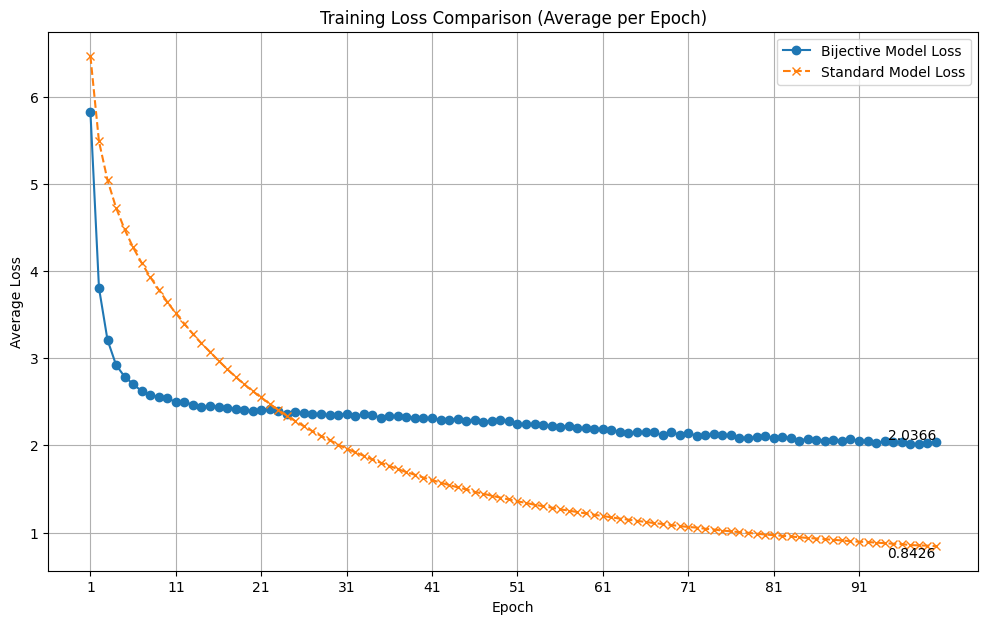

In [10]:
# 📈 PLOTTING TRAINING LOSSES

import matplotlib.pyplot as plt
import numpy as np

# Ensure the following variables are accessible from previous cells:
# losses (list of batch losses from bijective model training)
# standard_model_losses (list of batch losses from standard model training)
# train_loader (the DataLoader instance used for training)
# num_epochs (the number of epochs both models were trained for)

print("📈 Plotting Training Losses...\n" + "="*30)

if ('losses' in globals() and losses and
    'standard_model_losses' in globals() and standard_model_losses and
    'train_loader' in globals() and train_loader is not None and
    'num_epochs' in globals() and num_epochs > 0):

    num_batches_per_epoch = len(train_loader)

    # Calculate average loss per epoch for Bijective Model
    if len(losses) >= num_batches_per_epoch * num_epochs:
        bijective_epoch_avg_losses = [
            np.mean(losses[i * num_batches_per_epoch : (i + 1) * num_batches_per_epoch])
            for i in range(num_epochs)
        ]
    else:
        print("Warning: Not enough batch data in 'losses' to calculate all epoch averages for Bijective Model. Plotting available data.")
        # Fallback or partial calculation if needed, for now just a warning
        num_actual_bijective_epochs = len(losses) // num_batches_per_epoch
        bijective_epoch_avg_losses = [
            np.mean(losses[i * num_batches_per_epoch : (i + 1) * num_batches_per_epoch])
            for i in range(num_actual_bijective_epochs)
        ]


    # Calculate average loss per epoch for Standard Model
    if len(standard_model_losses) >= num_batches_per_epoch * num_epochs:
        standard_epoch_avg_losses = [
            np.mean(standard_model_losses[i * num_batches_per_epoch : (i + 1) * num_batches_per_epoch])
            for i in range(num_epochs)
        ]
    else:
        print("Warning: Not enough batch data in 'standard_model_losses' to calculate all epoch averages for Standard Model. Plotting available data.")
        num_actual_standard_epochs = len(standard_model_losses) // num_batches_per_epoch
        standard_epoch_avg_losses = [
            np.mean(standard_model_losses[i * num_batches_per_epoch : (i + 1) * num_batches_per_epoch])
            for i in range(num_actual_standard_epochs)
        ]

    min_epochs_plotted = min(len(bijective_epoch_avg_losses), len(standard_epoch_avg_losses))
    epochs_range = range(1, min_epochs_plotted + 1)


    if min_epochs_plotted > 0:
        plt.figure(figsize=(12, 7))
        plt.plot(epochs_range, bijective_epoch_avg_losses[:min_epochs_plotted], marker='o', linestyle='-', label='Bijective Model Loss')
        plt.plot(epochs_range, standard_epoch_avg_losses[:min_epochs_plotted], marker='x', linestyle='--', label='Standard Model Loss')

        plt.title('Training Loss Comparison (Average per Epoch)')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.legend()
        plt.grid(True)
        if min_epochs_plotted <= 20 : # Show all epoch ticks if not too many
             plt.xticks(list(epochs_range))
        else: # Otherwise, let matplotlib decide ticks or set specific interval
             plt.xticks(np.arange(1, min_epochs_plotted + 1, step=max(1, min_epochs_plotted // 10)))


        # Annotate final loss values
        if bijective_epoch_avg_losses:
            plt.text(epochs_range[-1], bijective_epoch_avg_losses[-1], f'{bijective_epoch_avg_losses[-1]:.4f}', va='bottom', ha='right')
        if standard_epoch_avg_losses:
            plt.text(epochs_range[-1], standard_epoch_avg_losses[-1], f'{standard_epoch_avg_losses[-1]:.4f}', va='top', ha='right')

        plt.show()
    else:
        print("No epoch average data available to plot.")

else:
    print("Could not plot: Required data (losses, standard_model_losses, train_loader, or num_epochs) not found or insufficient.")

print("\n" + "="*30)


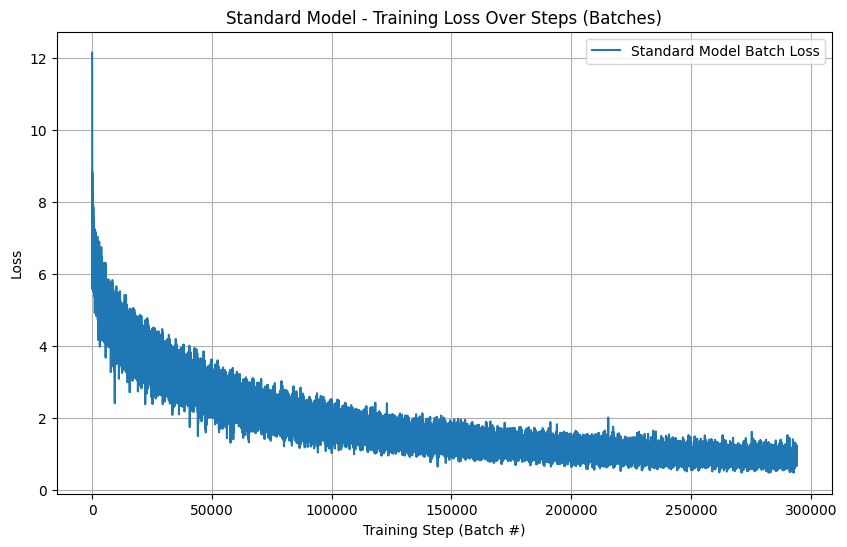

Plotted 294100 batch loss values for the Standard Model.


In [11]:
# 📈 STANDARD MODEL - TRAINING LOSS CURVE (PER BATCH)

import matplotlib.pyplot as plt
import numpy as np # Used if you want to do any processing like moving averages, but not for direct plot

# Ensure 'standard_model_losses' is accessible from the standard model's training cell
if 'standard_model_losses' in globals() and standard_model_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(standard_model_losses, label='Standard Model Batch Loss')
    plt.title('Standard Model - Training Loss Over Steps (Batches)')
    plt.xlabel('Training Step (Batch #)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Optional: If the loss list is very long, you might want to smooth it
    # For example, a simple moving average:
    # window_size = 50
    # if len(standard_model_losses) > window_size:
    #     smoothed_losses = np.convolve(standard_model_losses, np.ones(window_size)/window_size, mode='valid')
    #     plt.plot(np.arange(window_size-1, len(standard_model_losses)), smoothed_losses, label=f'Smoothed (window {window_size})', color='red', alpha=0.7)
    #     plt.legend() # Update legend if smoothed plot is added

    plt.show()
    print(f"Plotted {len(standard_model_losses)} batch loss values for the Standard Model.")
else:
    print("Could not plot: 'standard_model_losses' data not found or is empty. Please ensure the standard model training cell has run successfully.")



📊📈 Plotting Consolidated Training Losses...
Using smoothing window size: 100 for comparative plot.


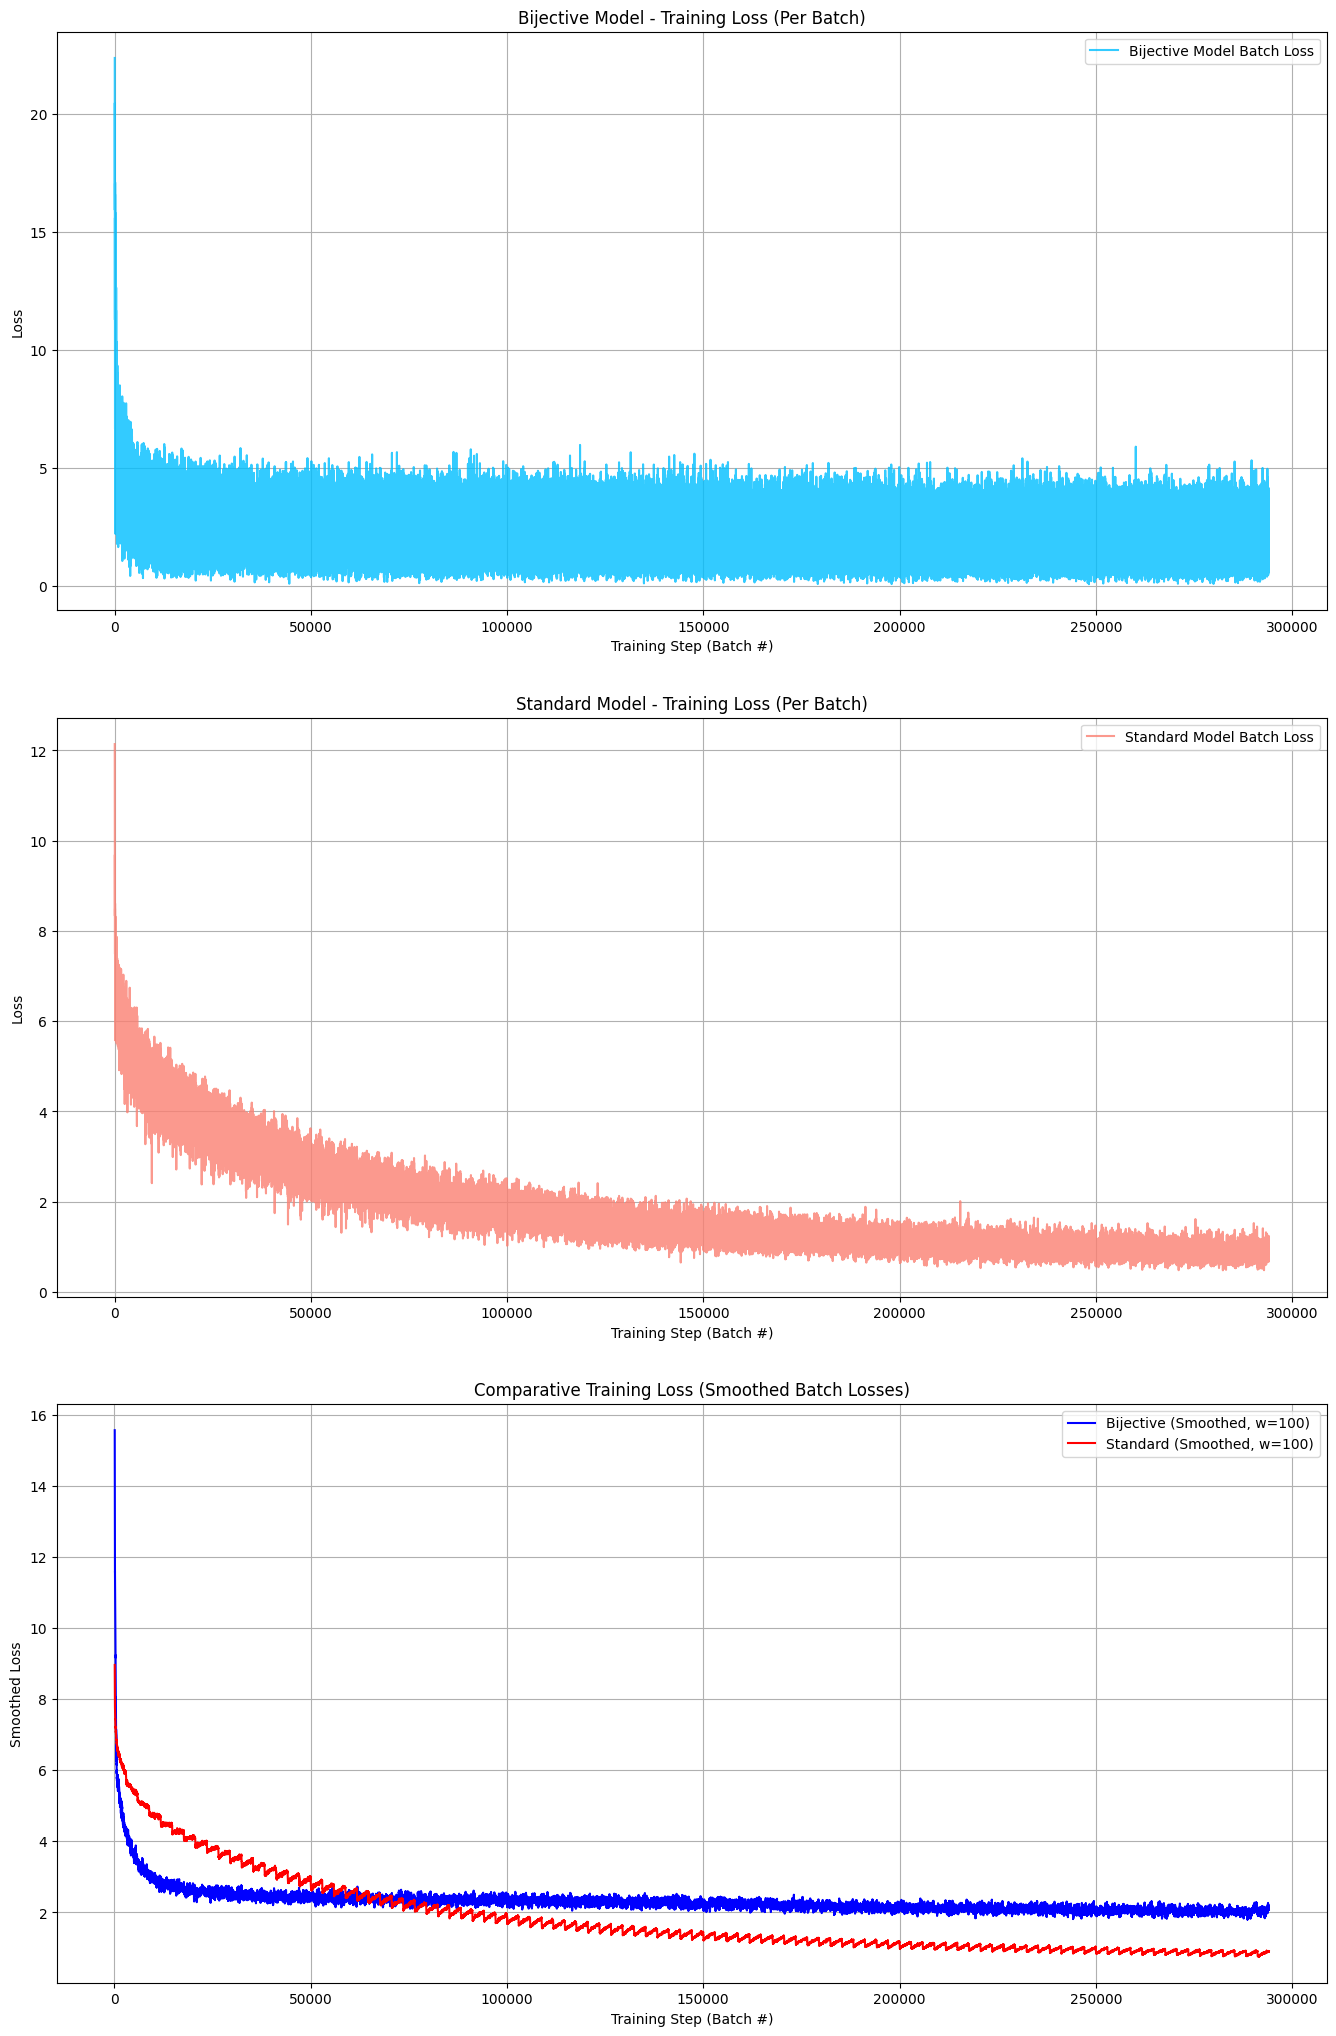

In [12]:
# 📊📈 CONSOLIDATED TRAINING LOSS PLOTS

import matplotlib.pyplot as plt
import numpy as np

# Ensure the following variables are accessible from previous cells:
# losses (list of batch losses from bijective model training)
# standard_model_losses (list of batch losses from standard model training)
# train_loader (the DataLoader instance, used to help determine smoothing window)

print("📊📈 Plotting Consolidated Training Losses...\n" + "="*40)

# Check if all required data is available
data_available = True
if 'losses' not in globals() or not losses:
    print("Warning: 'losses' data for Bijective Model not found or empty.")
    data_available = False
if 'standard_model_losses' not in globals() or not standard_model_losses:
    print("Warning: 'standard_model_losses' data for Standard Model not found or empty.")
    data_available = False
if 'train_loader' not in globals() or train_loader is None:
    print("Warning: 'train_loader' not found. Using a default smoothing window.")
    # data_available = False # Can still plot raw, but smoothing window needs a default

if not data_available and not ('losses' in globals() and standard_model_losses in globals()): # if neither is available
    print("Cannot generate plots: No loss data available.")
else:
    fig, axs = plt.subplots(3, 1, figsize=(14, 21)) # 3 rows, 1 column

    # --- Plot 1: Bijective Model - Batch Losses ---
    if 'losses' in globals() and losses:
        axs[0].plot(losses, label='Bijective Model Batch Loss', color='deepskyblue', alpha=0.8)
        axs[0].set_title('Bijective Model - Training Loss (Per Batch)')
        axs[0].set_xlabel('Training Step (Batch #)')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid(True)
    else:
        axs[0].text(0.5, 0.5, 'Bijective Model loss data not available.', ha='center', va='center')
        axs[0].set_title('Bijective Model - Training Loss (Per Batch)')


    # --- Plot 2: Standard Model - Batch Losses ---
    if 'standard_model_losses' in globals() and standard_model_losses:
        axs[1].plot(standard_model_losses, label='Standard Model Batch Loss', color='salmon', alpha=0.8)
        axs[1].set_title('Standard Model - Training Loss (Per Batch)')
        axs[1].set_xlabel('Training Step (Batch #)')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].grid(True)
    else:
        axs[1].text(0.5, 0.5, 'Standard Model loss data not available.', ha='center', va='center')
        axs[1].set_title('Standard Model - Training Loss (Per Batch)')

    # --- Plot 3: Comparative Plot - Smoothed Batch Losses ---
    axs[2].set_title('Comparative Training Loss (Smoothed Batch Losses)')
    axs[2].set_xlabel('Training Step (Batch #)')
    axs[2].set_ylabel('Smoothed Loss')
    plot_comparative_success = False

    if 'train_loader' in globals() and train_loader is not None:
        # Adaptive window size, e.g., 5% of an epoch's batches, min 10, max 100
        window_size = max(10, min(100, int(len(train_loader) * 0.05)))
    else:
        window_size = 50 # Default window if train_loader not found

    print(f"Using smoothing window size: {window_size} for comparative plot.")

    if 'losses' in globals() and losses and len(losses) > window_size:
        bijective_smoothed = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        # Adjust x-axis for 'valid' mode convolution: starts after window_size/2 batches effectively
        x_bijective = np.arange(window_size - 1, len(losses))
        axs[2].plot(x_bijective, bijective_smoothed, label=f'Bijective (Smoothed, w={window_size})', color='blue')
        plot_comparative_success = True
    elif 'losses' in globals() and losses: # Plot raw if not enough data to smooth
        axs[2].plot(losses, label='Bijective (Raw Batch Loss)', color='blue', alpha=0.5)
        print("Note: Plotting raw batch loss for Bijective Model as data is too short for smoothing.")
        plot_comparative_success = True


    if 'standard_model_losses' in globals() and standard_model_losses and len(standard_model_losses) > window_size:
        standard_smoothed = np.convolve(standard_model_losses, np.ones(window_size)/window_size, mode='valid')
        x_standard = np.arange(window_size - 1, len(standard_model_losses))
        axs[2].plot(x_standard, standard_smoothed, label=f'Standard (Smoothed, w={window_size})', color='red')
        plot_comparative_success = True
    elif 'standard_model_losses' in globals() and standard_model_losses: # Plot raw if not enough data to smooth
        axs[2].plot(standard_model_losses, label='Standard (Raw Batch Loss)', color='red', alpha=0.5)
        print("Note: Plotting raw batch loss for Standard Model as data is too short for smoothing.")
        plot_comparative_success = True

    if plot_comparative_success:
        axs[2].legend()
        axs[2].grid(True)
    else:
        axs[2].text(0.5, 0.5, 'Loss data for comparative plot not sufficient.', ha='center', va='center')

    plt.tight_layout(pad=3.0) # Add padding between subplots
    plt.show()

print("\n" + "="*40)
